In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2425 sha256=d22251bef28a2aad4a03a154b94ba91a2d4606f14c38cb39538d7376c37ea9cc
  Stored in directory: /root/.cache/pip/wheels/54/1d/51/d65a99106096dd07e3be6f08d5d3c2dd5f26ac98f626e5efc9
Successfully built colabgymrender


In [3]:
from colabgymrender.recorder import Recorder

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [4]:
# install dependencies
!apt install chromium-browser xvfb

  and should_run_async(code)



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfontenc1 libfuse3-3 liblzo2-2 libudev1 libxfont2 libxkbfile1 snapd squashfs-tools
  systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfontenc1 libfuse3-3 liblzo2-2 libxfont2 libxkbfile1 snapd
  squashfs-tools systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
The following packages will be upgraded:
  libudev1
1 upgraded, 17 newly installed, 0 to remove and 44 not upgraded.
Need to get 36.2 MB of archives.
After this operation, 129 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.3 [595 kB]


In [5]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [6]:
total_reward

  and should_run_async(code)



-200.0

In [36]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000 # Increased due to higher complexity and longer training time
epsilon_decay_intervals = 5000 # Decay epsilon slower due to longer training
gamma = 0.99
alpha = 0.001 # Slightly higher learning rate to adapt faster to sparse rewards

memory_size = 100000 # Larger replay memory to accommodate more experiences
min_replay_size = 2000 # Start training after collecting more experiences
batch_size = 64 # Larger batch size for better gradient estimates

target_update_frequency = 100 # Update the target network frequently

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [38]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [39]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [40]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -195.2
Episode: 30 Step: 6000 Average reward: -196.0
Episode: 36 Step: 7000 Average reward: -193.63888888888889
Episode: 41 Step: 8000 Average reward: -194.41463414634146
Episode: 46 Step: 9000 Average reward: -194.95652173913044
Episode: 51 Step: 10000 Average reward: -195.45098039215685
Episode: 56 Step: 11000 Average reward: -195.85714285714286
Episode: 61 Step: 12000 Average reward: -194.80327868852459
Episode: 66 Step: 13000 Average reward: -194.9848484848485
Episode: 72 Step: 14000 Average reward: -194.40277777777777
Episode: 77 Step: 15000 Average reward: -194.44155844155844
Episode: 82 Step: 16000 Average reward: -193.23170731707316
Episode: 87 Step: 17000 Average reward: -193.44827586206895
Episode: 92 Step: 18000 Average reward: -193.59782608695653
Episode: 

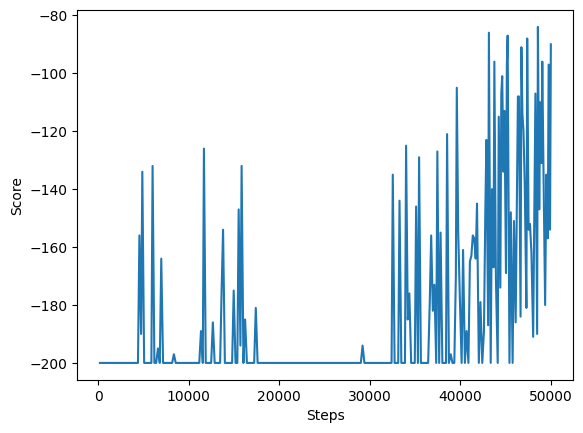

In [41]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [42]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-143.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
